In [1]:
import torch
from torch import nn
from torchinfo import summary
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn.functional as F
import matplotlib.pyplot as plt

from going_modular.custom_data_setup_main_train import LoadDataset
from going_modular import engine, utils
from going_modular import custom_data_setup_main_train
from going_modular.ThreeHeadCNN import ThreeHeadCNN
import helper_functions

c:\Users\User\.conda\envs\EnvMasoudi\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\User\.conda\envs\EnvMasoudi\lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
allow_train = True
load_pre_train_model = True
freeze_encoder = False
EPOCHS = 40
BATCH_SIZE = 128
shrink_size = None

lr = 1e-3
weight_deacay = 1e-4
T_max = 15
eta_min = 1e-4
num_augs = 3
p_dropout = 0.5
pos_weight = torch.tensor([3.0])

crop_size = 240

# weights for alpha is inverse frequency
# alpha = torch.tensor([1/1805, 1/370, 1/999, 1/193, 1/295]) * 500 
# alpha = torch.tensor([0.25, 0.25, 0.25, 0.25, 0.25])

# alpha = [1] * 5
# alpha = [1/1805, 1/370, 1/999, 1/193, 1/295] * 500 
alpha = 1
gamma = 1

In [3]:
# Set matmul precision for TF32 usage on Ampere+ GPUs
# torch.set_float32_matmul_precision('medium')

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Augmentation

In [4]:
train_transforms = helper_functions.get_augmentation_train_transforms(num_augs, crop_size)
test_transforms = helper_functions.get_augmentation_test_transforms()
no_transforms = helper_functions.get_augmentation_no_transforms()

In [5]:
# load all dataloaders

train_val_dataloader, class_names = custom_data_setup_main_train.create_train_val_dataloader(
    batch_size=BATCH_SIZE,
    train_transform=train_transforms,
    val_transform=test_transforms,
    shrink_size=shrink_size)

test_dataloader, class_names = custom_data_setup_main_train.create_test_dataloader(
    batch_size=BATCH_SIZE,
    test_transform=test_transforms, 
    shrink_size=shrink_size) 

exp_dataloader, class_names = custom_data_setup_main_train.create_train_dataloader(
    batch_size=BATCH_SIZE,
    train_transform=train_transforms,
    shrink_size=shrink_size)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2489083].


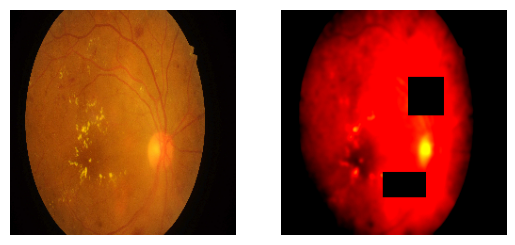

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2489083].


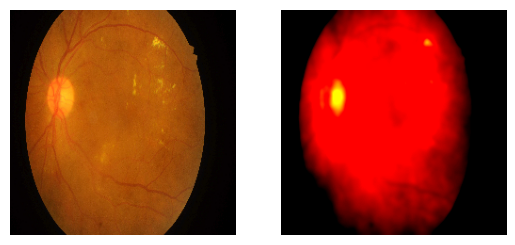

In [6]:
# plot some of the images to check applied augmentations

IDRID_image_folder = "../IDRID/Imagenes/Imagenes" 
IDRID_csv_file = "../IDRID/idrid_labels.csv"  

test_dataset_with_transform = LoadDataset(IDRID_image_folder, IDRID_csv_file, transform=train_transforms)
test_dataset_no_transform = LoadDataset(IDRID_image_folder, IDRID_csv_file, transform=no_transforms)

for i in range(2):
    img_2 = test_dataset_with_transform[i][0].permute(1, 2, 0)
    img_1 = test_dataset_no_transform[i][0].permute(1, 2, 0)
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(img_1.numpy())
    axes[1].imshow(img_2.numpy())
    axes[0].axis(False)
    axes[1].axis(False)
    plt.show()

In [7]:
model = ThreeHeadCNN(device=device, p_dropout=p_dropout).to(device)

In [8]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
def prepare_model():
    if load_pre_train_model:
        model.load_state_dict(torch.load("models/pre_train_model.pth", weights_only=True, map_location=device))

        # As the paper has stated, we reinitialize the heads weights
        model.classification_head = nn.Sequential(
                                    nn.Linear(512, 128),
                                    nn.ReLU(),
                                    nn.Dropout(p=p_dropout),
                                    nn.Linear(128, 1) # 5 output nodes for classification
                                    )
        
        nn.init.kaiming_normal_(model.dense1.weight, mode='fan_in', nonlinearity='relu')
        if model.dense1.bias is not None:
            nn.init.zeros_(model.dense1.bias)

        for module in model.classification_head:
            if isinstance(module, nn.Linear):
                # Apply He initialization to weights
                nn.init.kaiming_normal_(module.weight, mode='fan_in', nonlinearity='relu')
                # Initialize biases to zero (optional, common practice)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)


In [9]:
# Print a summary using torchinfo (uncomment for actual output)
torch.manual_seed(33)
summary(model=model, 
        input_size=(32, 3, 240, 240), # make sure this is "input_size", not "input_shape"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ThreeHeadCNN (ThreeHeadCNN)                                  [32, 3, 240, 240]    [32]                 --                   True
├─Sequential (encoder)                                       [32, 3, 240, 240]    [32, 1280, 8, 8]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 240, 240]    [32, 32, 120, 120]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 240, 240]    [32, 32, 120, 120]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 120, 120]   [32, 32, 120, 120]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 120, 120]   [32, 32, 120, 120]   --                   --
│    └─Sequential (1)                                        [32, 32, 120, 120]   [32, 16, 120

Custom Focal Loss function

In [10]:
# class FocalLoss_custom(torch.nn.Module):
#     def __init__(self, alpha, gamma, headType=None):
#         super(FocalLoss_custom, self).__init__()
#         self.alpha = alpha.to(device)
#         self.gamma = gamma
#         self.headType = headType
#     def forward(self, inputs, targets):
        
#         ce_loss = F.cross_entropy(inputs, targets, reduction='none', label_smoothing=0.1)
#         # apply class weights
#         # alpha is for the weight class, weights is the correct weight for each class and looks like this: tensor([a, b, c, d, a, ...])
#         weights = self.alpha.gather(0, targets)

#         pt = torch.exp(-ce_loss)
#         loss = (weights * ((1 - pt) ** self.gamma) * ce_loss)
#         # loss = (self.alpha * ((1 - pt) ** self.gamma) * ce_loss)
#         return loss.mean()

In [11]:
from going_modular.focal_loss import FocalLoss

In [12]:
# Define loss and optimizer

# weights are selected based on the APTOS 2019 distribution according to the paper
# weights = torch.Tensor([3260/1750, 3260/270, 3260/840, 3260/140, 3260/260]) * 0.1
# weights.to(device)

loss_fn_classification = nn.BCEWithLogitsLoss(pos_weight=pos_weight).to(device)
# loss_fn_classification = nn.CrossEntropyLoss().to(device)
# loss_fn_classification = nn.CrossEntropyLoss(weight=weights).to(device)
# loss_fn_classification = FocalLoss_custom(headType='classification', alpha=alpha, gamma=gamma).to(device)
# loss_fn_classification = FocalLoss(gamma=gamma, alpha=alpha, task_type='multi-class', num_classes=5).to(device)
# loss_fn_classification = FocalLoss(gamma=gamma, alpha=alpha, task_type='binary', num_classes=2).to(device)

optimizer = torch.optim.RAdam(model.parameters(), lr=lr, weight_decay=weight_deacay)
scheduler = CosineAnnealingLR(optimizer, T_max=T_max, eta_min=eta_min)


fold 1:



100%|██████████| 5/5 [01:17<00:00, 15.51s/it]


Epoch: 5
loss_classification_train: 0.6619 | loss_classification_validation: 0.3485 | acc_classification_validation: 0.8891

Now the encoder will be trained...



 12%|█▎        | 5/40 [00:57<06:41, 11.48s/it]

Epoch: 5
loss_classification_train: 0.4909 | loss_classification_validation: 0.2895 | acc_classification_validation: 0.9200


 25%|██▌       | 10/40 [01:55<05:44, 11.48s/it]

Epoch: 10
loss_classification_train: 0.3916 | loss_classification_validation: 0.2367 | acc_classification_validation: 0.9254


 38%|███▊      | 15/40 [02:53<04:48, 11.53s/it]

Epoch: 15
loss_classification_train: 0.3578 | loss_classification_validation: 0.2326 | acc_classification_validation: 0.9275


 50%|█████     | 20/40 [03:50<03:50, 11.53s/it]

Epoch: 20
loss_classification_train: 0.3625 | loss_classification_validation: 0.2611 | acc_classification_validation: 0.9275


 62%|██████▎   | 25/40 [04:48<02:52, 11.48s/it]

Epoch: 25
loss_classification_train: 0.3080 | loss_classification_validation: 0.3003 | acc_classification_validation: 0.9382


 75%|███████▌  | 30/40 [05:46<01:55, 11.52s/it]

Epoch: 30
loss_classification_train: 0.3021 | loss_classification_validation: 0.2441 | acc_classification_validation: 0.9179


 88%|████████▊ | 35/40 [06:42<00:57, 11.41s/it]

Epoch: 35
loss_classification_train: 0.2750 | loss_classification_validation: 0.2709 | acc_classification_validation: 0.9275


100%|██████████| 40/40 [07:40<00:00, 11.52s/it]

Epoch: 40
loss_classification_train: 0.2829 | loss_classification_validation: 0.3423 | acc_classification_validation: 0.9286


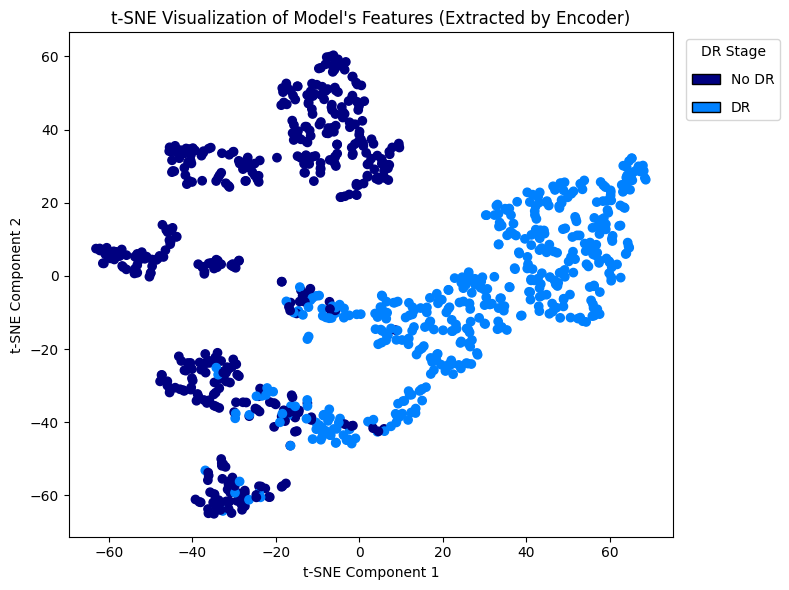

[INFO] Saving model to: models\main_train_model_1.pth

fold 2:



100%|██████████| 5/5 [01:17<00:00, 15.54s/it]


Epoch: 5
loss_classification_train: 0.5371 | loss_classification_validation: 0.3650 | acc_classification_validation: 0.8891

Now the encoder will be trained...



 12%|█▎        | 5/40 [00:57<06:41, 11.46s/it]

Epoch: 5
loss_classification_train: 0.4478 | loss_classification_validation: 0.4187 | acc_classification_validation: 0.8316


 25%|██▌       | 10/40 [01:54<05:43, 11.46s/it]

Epoch: 10
loss_classification_train: 0.3431 | loss_classification_validation: 0.3336 | acc_classification_validation: 0.8785


 38%|███▊      | 15/40 [02:52<04:47, 11.49s/it]

Epoch: 15
loss_classification_train: 0.3334 | loss_classification_validation: 0.3263 | acc_classification_validation: 0.8934


 50%|█████     | 20/40 [03:50<03:51, 11.56s/it]

Epoch: 20
loss_classification_train: 0.2577 | loss_classification_validation: 0.4686 | acc_classification_validation: 0.8923


 62%|██████▎   | 25/40 [04:47<02:51, 11.46s/it]

Epoch: 25
loss_classification_train: 0.2629 | loss_classification_validation: 0.4906 | acc_classification_validation: 0.9222


 75%|███████▌  | 30/40 [05:45<01:54, 11.50s/it]

Epoch: 30
loss_classification_train: 0.2487 | loss_classification_validation: 0.3826 | acc_classification_validation: 0.9286


 88%|████████▊ | 35/40 [06:42<00:57, 11.53s/it]

Epoch: 35
loss_classification_train: 0.2468 | loss_classification_validation: 0.4356 | acc_classification_validation: 0.9318


100%|██████████| 40/40 [07:40<00:00, 11.51s/it]

Epoch: 40
loss_classification_train: 0.2059 | loss_classification_validation: 0.6387 | acc_classification_validation: 0.9115


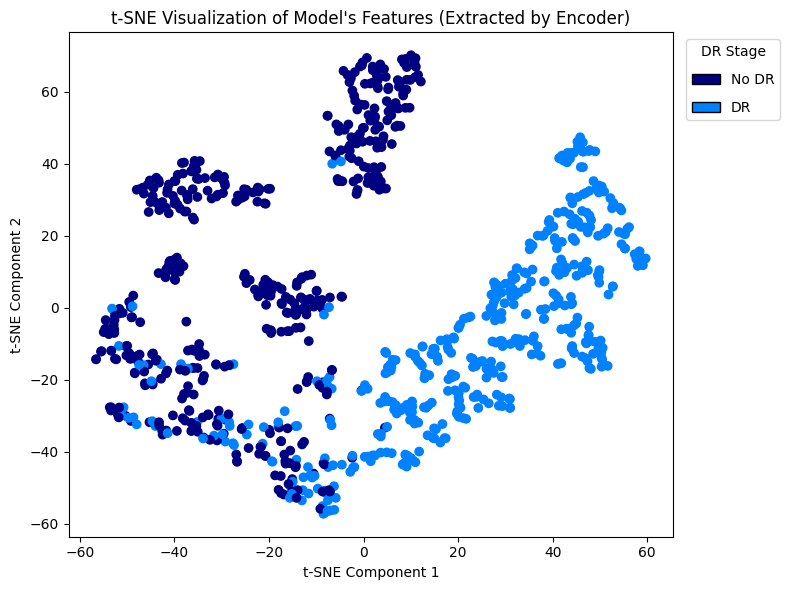

[INFO] Saving model to: models\main_train_model_2.pth

fold 3:



100%|██████████| 5/5 [01:18<00:00, 15.66s/it]


Epoch: 5
loss_classification_train: 0.5241 | loss_classification_validation: 0.3991 | acc_classification_validation: 0.8412

Now the encoder will be trained...



 12%|█▎        | 5/40 [00:59<06:53, 11.80s/it]

Epoch: 5
loss_classification_train: 0.4142 | loss_classification_validation: 0.4511 | acc_classification_validation: 0.8977


 25%|██▌       | 10/40 [01:57<05:53, 11.79s/it]

Epoch: 10
loss_classification_train: 0.3921 | loss_classification_validation: 0.3967 | acc_classification_validation: 0.8859


 38%|███▊      | 15/40 [02:56<04:51, 11.66s/it]

Epoch: 15
loss_classification_train: 0.3069 | loss_classification_validation: 0.3442 | acc_classification_validation: 0.8859


 50%|█████     | 20/40 [03:55<03:52, 11.64s/it]

Epoch: 20
loss_classification_train: 0.3078 | loss_classification_validation: 0.3503 | acc_classification_validation: 0.9019


 62%|██████▎   | 25/40 [04:53<02:54, 11.62s/it]

Epoch: 25
loss_classification_train: 0.2531 | loss_classification_validation: 0.4432 | acc_classification_validation: 0.8987


 75%|███████▌  | 30/40 [05:52<01:56, 11.66s/it]

Epoch: 30
loss_classification_train: 0.2120 | loss_classification_validation: 0.4244 | acc_classification_validation: 0.8945


 88%|████████▊ | 35/40 [06:50<00:57, 11.60s/it]

Epoch: 35
loss_classification_train: 0.2198 | loss_classification_validation: 0.4362 | acc_classification_validation: 0.9168


100%|██████████| 40/40 [07:49<00:00, 11.73s/it]

Epoch: 40
loss_classification_train: 0.1866 | loss_classification_validation: 0.4632 | acc_classification_validation: 0.8774


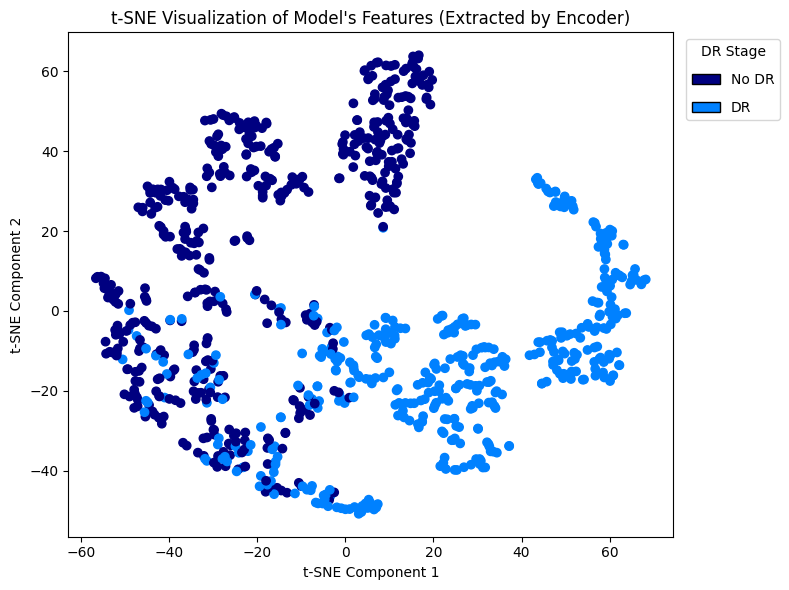

[INFO] Saving model to: models\main_train_model_3.pth

fold 4:



100%|██████████| 5/5 [01:18<00:00, 15.63s/it]


Epoch: 5
loss_classification_train: 0.5942 | loss_classification_validation: 0.3310 | acc_classification_validation: 0.9018

Now the encoder will be trained...



 12%|█▎        | 5/40 [00:58<06:45, 11.58s/it]

Epoch: 5
loss_classification_train: 0.4792 | loss_classification_validation: 0.3137 | acc_classification_validation: 0.8943


 25%|██▌       | 10/40 [01:56<05:51, 11.73s/it]

Epoch: 10
loss_classification_train: 0.3312 | loss_classification_validation: 0.3101 | acc_classification_validation: 0.9018


 38%|███▊      | 15/40 [02:55<04:53, 11.73s/it]

Epoch: 15
loss_classification_train: 0.3453 | loss_classification_validation: 0.2962 | acc_classification_validation: 0.8869


 50%|█████     | 20/40 [03:53<03:55, 11.76s/it]

Epoch: 20
loss_classification_train: 0.2964 | loss_classification_validation: 0.3003 | acc_classification_validation: 0.9189


 62%|██████▎   | 25/40 [04:51<02:54, 11.64s/it]

Epoch: 25
loss_classification_train: 0.2566 | loss_classification_validation: 0.3260 | acc_classification_validation: 0.9210


 75%|███████▌  | 30/40 [05:49<01:56, 11.63s/it]

Epoch: 30
loss_classification_train: 0.2303 | loss_classification_validation: 0.5605 | acc_classification_validation: 0.9296


 88%|████████▊ | 35/40 [06:48<00:58, 11.64s/it]

Epoch: 35
loss_classification_train: 0.2266 | loss_classification_validation: 0.3912 | acc_classification_validation: 0.9007


100%|██████████| 40/40 [07:46<00:00, 11.65s/it]

Epoch: 40
loss_classification_train: 0.2173 | loss_classification_validation: 0.3330 | acc_classification_validation: 0.9146


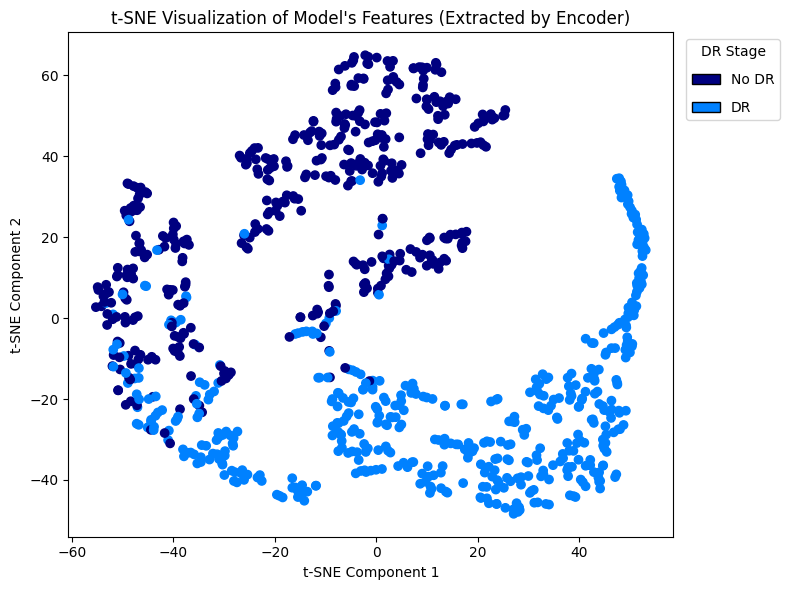

[INFO] Saving model to: models\main_train_model_4.pth

fold 5:



100%|██████████| 5/5 [01:16<00:00, 15.29s/it]


Epoch: 5
loss_classification_train: 0.4874 | loss_classification_validation: 0.4617 | acc_classification_validation: 0.8751

Now the encoder will be trained...



 12%|█▎        | 5/40 [00:57<06:40, 11.44s/it]

Epoch: 5
loss_classification_train: 0.4591 | loss_classification_validation: 0.3513 | acc_classification_validation: 0.9050


 25%|██▌       | 10/40 [01:54<05:41, 11.39s/it]

Epoch: 10
loss_classification_train: 0.3206 | loss_classification_validation: 0.3888 | acc_classification_validation: 0.8794


 38%|███▊      | 15/40 [02:52<04:47, 11.48s/it]

Epoch: 15
loss_classification_train: 0.3113 | loss_classification_validation: 0.3527 | acc_classification_validation: 0.8997


 50%|█████     | 20/40 [03:50<03:52, 11.60s/it]

Epoch: 20
loss_classification_train: 0.2730 | loss_classification_validation: 0.3794 | acc_classification_validation: 0.8698


 62%|██████▎   | 25/40 [04:48<02:54, 11.60s/it]

Epoch: 25
loss_classification_train: 0.2452 | loss_classification_validation: 0.4258 | acc_classification_validation: 0.9146


 75%|███████▌  | 30/40 [05:46<01:55, 11.53s/it]

Epoch: 30
loss_classification_train: 0.2260 | loss_classification_validation: 0.4326 | acc_classification_validation: 0.8719


 88%|████████▊ | 35/40 [06:44<00:57, 11.53s/it]

Epoch: 35
loss_classification_train: 0.2656 | loss_classification_validation: 0.4886 | acc_classification_validation: 0.9093


100%|██████████| 40/40 [07:41<00:00, 11.55s/it]

Epoch: 40
loss_classification_train: 0.2229 | loss_classification_validation: 0.4357 | acc_classification_validation: 0.9061


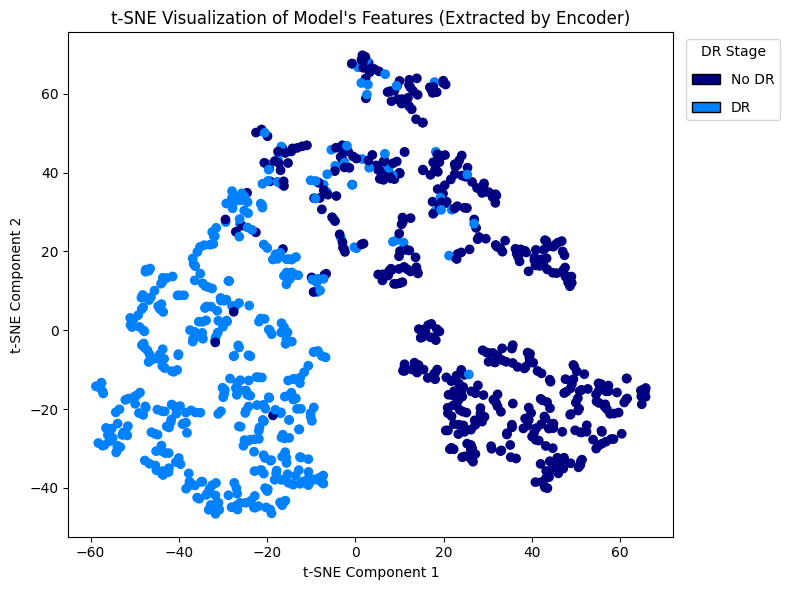

[INFO] Saving model to: models\main_train_model_5.pth
[INFO] Total training time: 2723.539 seconds


In [13]:
torch.cuda.empty_cache()

folds_train_results = {
    'loss_classification_train': [],
}
folds_val_results = {
    'loss_classification_val': [],
}

if allow_train:
    # Set the random seeds
    torch.manual_seed(1404)
    torch.cuda.manual_seed(1404)

    # Start the timer
    from timeit import default_timer as timer 
    start_time = timer()

    # Setup training and save the results
    for index, fold in enumerate(train_val_dataloader):

        print(f'\nfold {index+1}:\n')

        prepare_model() # restet model's weights to pre train for each fold

        # Freeze all base layers in the "features" section of the model 
        for param in model.encoder.parameters():
            param.requires_grad = False
        
        # training for 5 epochs to save pre train weights
        _, _ = engine.train(model=model,
                    train_dataloader=fold['train_dataloader'],
                    val_dataloader=fold['val_dataloader'],
                    optimizer=optimizer,
                    scheduler=scheduler,
                    loss_fn_classification=loss_fn_classification,
                    epochs=5,
                    device=device)
        
        print('\nNow the encoder will be trained...\n')
        
        # UnFreeze all base layers in the "features" section of the model 
        for param in model.encoder.parameters():
            param.requires_grad = True

        train_results, val_results = engine.train(model=model,
                    train_dataloader=fold['train_dataloader'],
                    val_dataloader=fold['val_dataloader'],
                    optimizer=optimizer,
                    scheduler=scheduler,
                    loss_fn_classification=loss_fn_classification,
                    epochs=EPOCHS,
                    device=device)
        
        folds_train_results['loss_classification_train'].extend(train_results['loss_classification_train'])

        folds_val_results['loss_classification_val'].extend(val_results['loss_classification_val'])

        helper_functions.plot_t_SNE(model=model,
                                dataloader=fold['val_dataloader'],
                                NUM_ITER=2000)
        
        utils.save_model(model=model, target_dir='models', model_name=f'main_train_model_{index+1}.pth')

    # End the timer and print out how long it took
    end_time = timer()
    print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")
else:
    model.load_state_dict(torch.load('models/main_train_model.pth', weights_only=True, map_location=device))

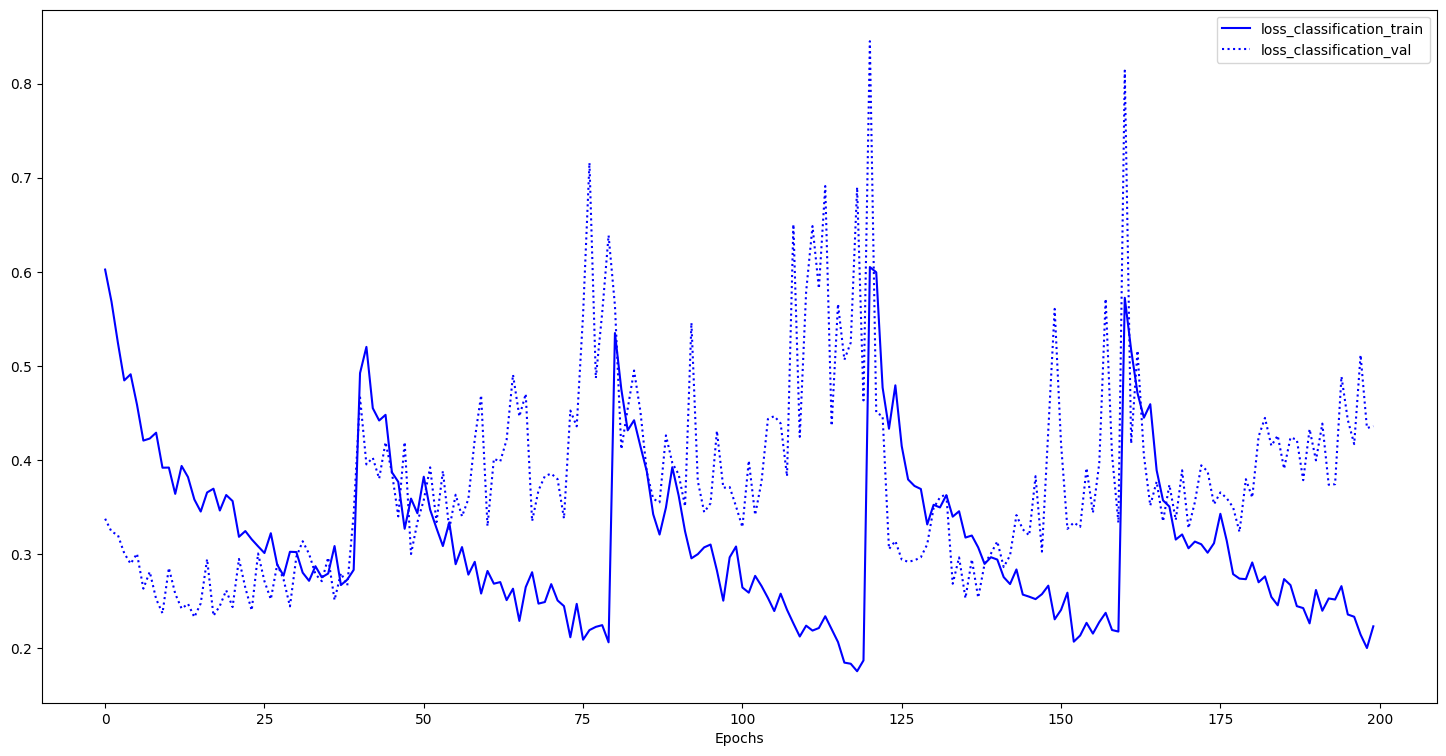

In [14]:
if allow_train:
    helper_functions.plot_loss_curves_main_train(folds_train_results, folds_val_results)

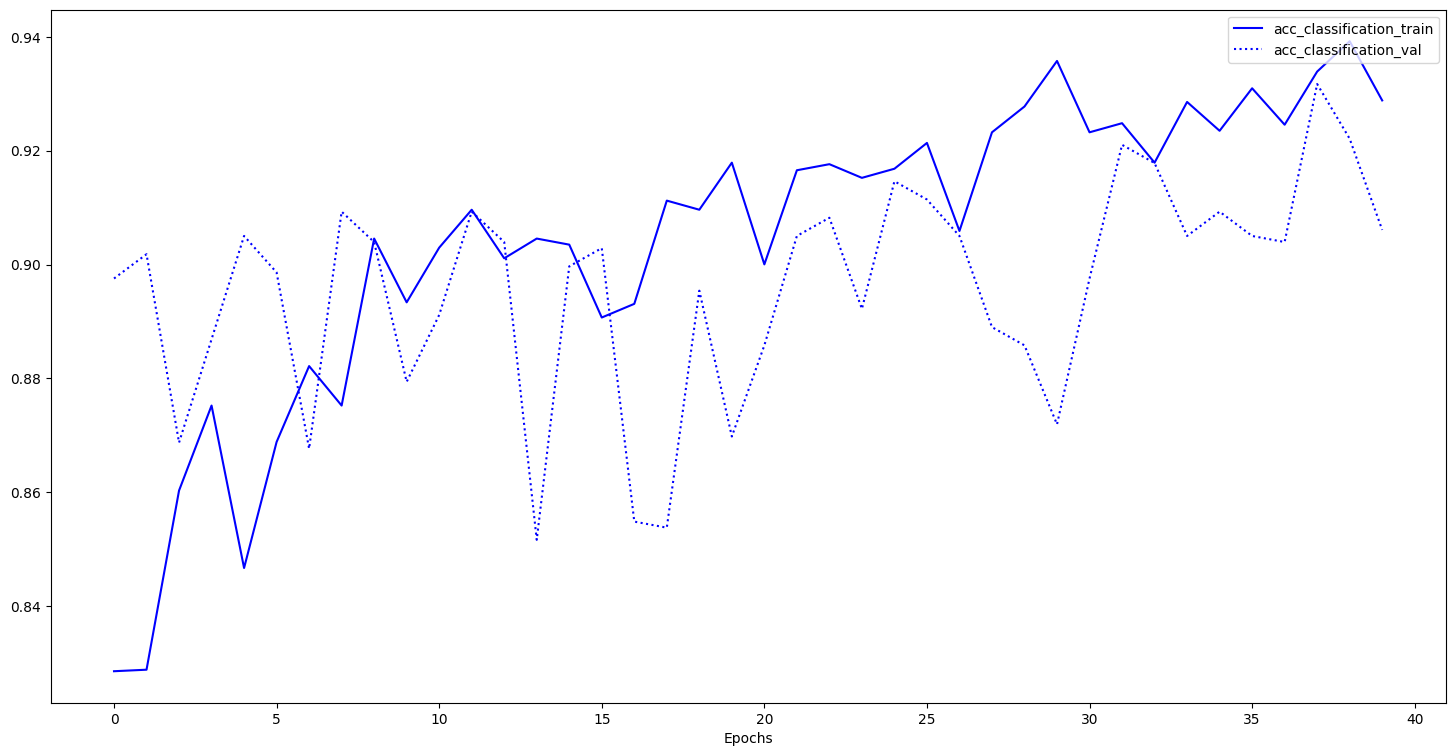

In [15]:
if allow_train:
    helper_functions.plot_acc_curves(train_results, val_results)

In [16]:
test_results = engine.test_step(model=model,
            dataloader=test_dataloader,
            loss_fn_classification=loss_fn_classification,
            device=device)

precision: 0.9081 | recall: 0.9073 | f1_score: 0.9070 | accuracy: 0.9071


In [17]:
test_results = engine.test_step(model=model,
            dataloader=exp_dataloader,
            loss_fn_classification=loss_fn_classification,
            device=device)

precision: 0.9293 | recall: 0.9242 | f1_score: 0.9236 | accuracy: 0.9238


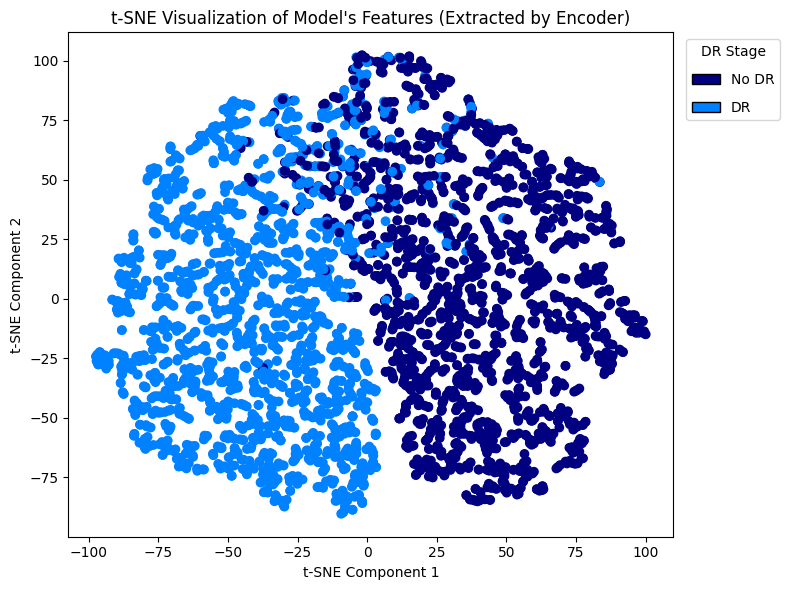

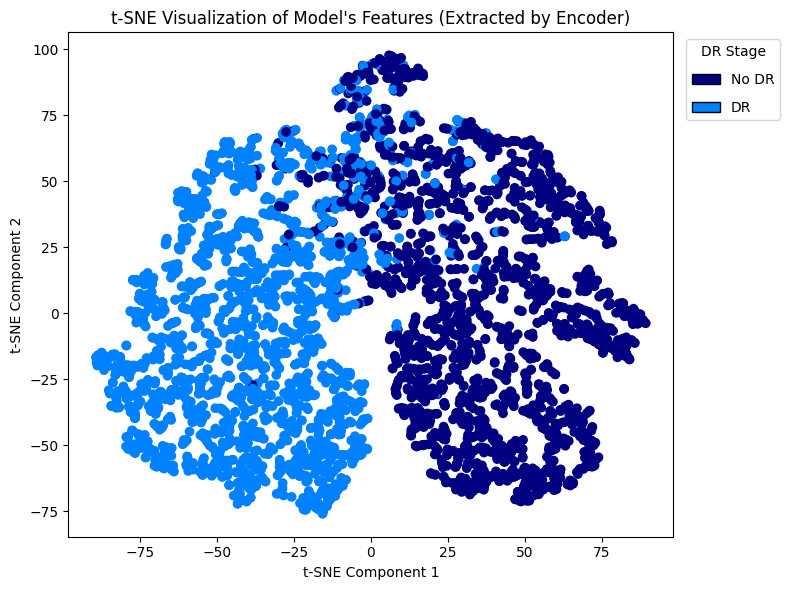

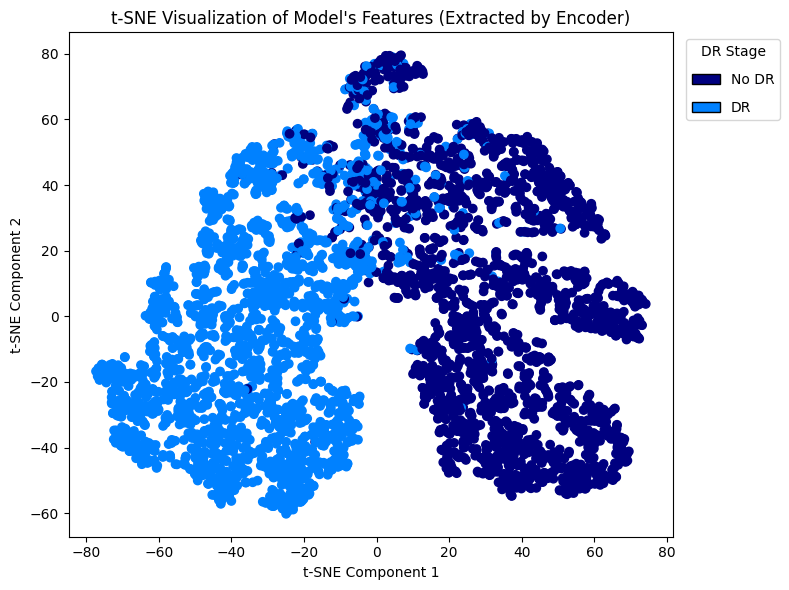

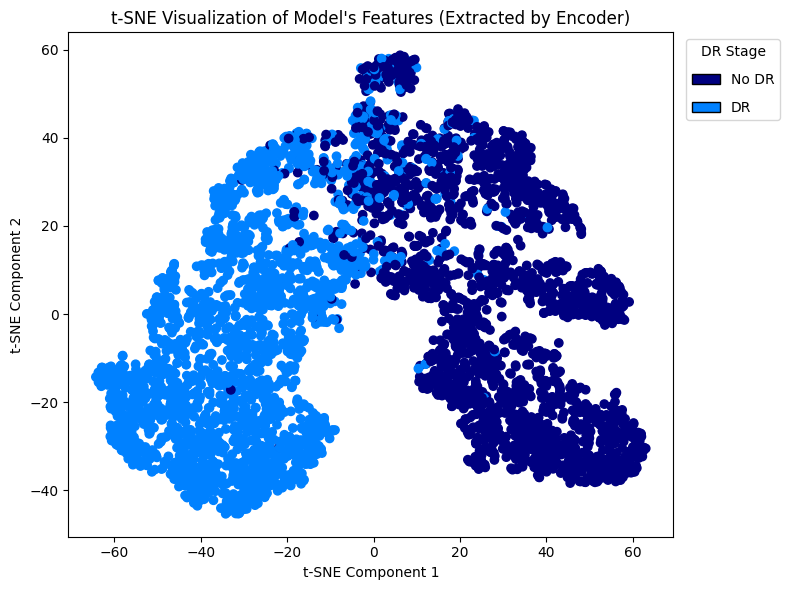

In [18]:
helper_functions.plot_t_SNE(model=model,
                        dataloader=exp_dataloader,
                        perp_vals=[5, 10, 20, 40],
                        NUM_ITER=2000)